In [204]:
%run ./Initialization.ipynb

import random as rndm
import csv
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

nsamples = 100 #1000

set_plot_style(usetex=False)
print("Number of used CPU cores: %d"%num_cores)

2019年 10月  2日 水曜日 15:28:21 JST
3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Running with PyMC3 version v.3.7
Running with arviz version v.0.4.1
Running with pandas version v.0.25.1
Running with Theano version v.1.0.4
Number of used CPU cores: 48


In [205]:
Df_raw = pd.read_csv("ADSM-states.csv",sep=",")
Df_raw[:5]

,run,day,ID,status,Lat,Lon
0,2,1,31,C,33.515,-37.5675
1,2,2,31,C,33.515,-37.5675
2,2,2,2728,L,33.552,-37.7507
3,2,3,31,C,33.515,-37.5675
4,2,3,1922,L,33.407,-37.2380


In [206]:
# selecting only the clinical detection
Df = Df_raw.loc[lambda d: d.status=='C'].groupby('ID').first().drop(['run','status'],1).reset_index().sort_values('day')
Df[:5]

,ID,day,Lat,Lon
3,31,1,33.515,-37.5675
298,2728,7,33.552,-37.7507
215,1922,9,33.407,-37.2380
83,715,10,33.302,-37.0091
364,3267,11,33.990,-37.6930


In [207]:
xmax = np.max(Df['day'])

df_epi = Df.groupby('day').size()
df_epi = pd.DataFrame(df_epi,columns=['n']).reset_index()
df_epi = pd.DataFrame({'day': range(xmax+5)}).merge(df_epi,how='left').fillna(0)
df_epi['n'] = df_epi['n'].astype(int)
display(df_epi[:5])
df_epi[-5:]

,day,n
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0


,day,n
129,129,1
130,130,0
131,131,0
132,132,0
133,133,0


In [208]:
p_reported = .50

df_epi['n_after_removal'] = pm.Binomial.dist(n = df_epi['n'], p = p_reported, shape=df_epi.shape[0]).random(size=1)
df_epi[-5:]

,day,n,n_after_removal
129,129,1,1
130,130,0,0
131,131,0,0
132,132,0,0
133,133,0,0


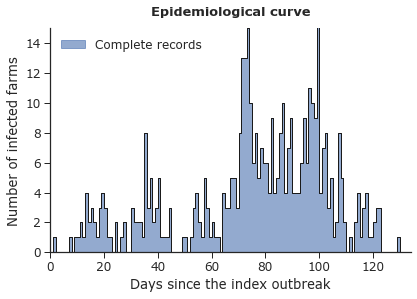

In [209]:
fig, ax = plt.subplots(1)
fig_sz = [6,4.5]
fig.set_size_inches(fig_sz);

ymax = 15

ax.step(df_epi['day'].append(df_epi['day'][-1:]+1),
        df_epi['n'].append(df_epi['n'][-1:]),
        where='post',color='k',lw=1)
ax.fill_between(df_epi['day'].append(df_epi['day'][-1:]+1),
                df_epi['n'].append(df_epi['n'][-1:]),
                step='post',alpha=.6,color='C0',label='Complete records')

ax.set_xlim(np.min(df_epi['day']),np.max(df_epi['day'])+1)
ax.set_ylim(0,ymax
        )

ax.set_xlabel('Days since the index outbreak')
ax.set_ylabel('Number of infected farms')

ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
ax.set_title('Epidemiological curve',size=13, y=1.03,fontweight="bold");
ax.legend(fontsize=12,frameon=False,loc=2)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("../../figures/draft/AppendixFig-ADSM-Epicurve-1.pdf",format='pdf',bbox_inches='tight')

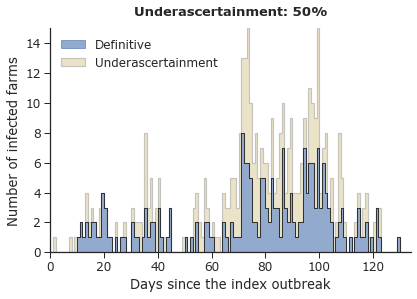

In [210]:
fig, ax = plt.subplots(1)
fig.set_size_inches(fig_sz); 

ax.fill_between(df_epi['day'].append(df_epi['day'][-1:]+1),
                df_epi['n_after_removal'].append(df_epi['n_after_removal'][-1:]),
                step='post',alpha=.6,color='C0',lw=1,label='Definitive')

ax.fill_between(df_epi['day'].append(df_epi['day'][-1:]+1),
                df_epi['n_after_removal'].append(df_epi['n_after_removal'][-1:]),
                df_epi['n'].append(df_epi['n'][-1:]),
                step='post',alpha=.4,facecolor='C8',edgecolor='grey',lw=1.2,label='Underascertainment')

ax.step(df_epi['day'].append(df_epi['day'][-1:]+1),
        df_epi['n_after_removal'].append(df_epi['n_after_removal'][-1:]),
        where='post',color='k',lw=.8)

ax.set_xlim(np.min(df_epi['day']),np.max(df_epi['day'])+1)
ax.set_ylim(0,ymax)

ax.set_xlabel('Days since the index outbreak')
ax.set_ylabel('Number of infected farms')

ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
ax.set_title('Underascertainment: %.0f%%'%(p_reported*100),size=13, y=1.03,fontweight="bold");
ax.legend(fontsize=12,frameon=False,loc=2)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("../../figures/draft/AppendixFig-ADSM-Epicurve-2.pdf",format='pdf',bbox_inches='tight')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 13.461:   3%|▎         | 6666/200000 [00:02<00:59, 3231.60it/s]
Convergence achieved at 6800
Interrupted at 6,799 [3%]: Average Loss = 21.949
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gtSD, α, Y, X]
Sampling 4 chains: 100%|██████████| 32000/32000 [00:12<00:00, 2516.50draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
gtmean,9.455843,1.968377,0.037678,6.043463,13.417218,2675.177019,1.000775
gtSD,2.304795,0.588669,0.006017,1.230110,3.499542,10876.442296,0.999995


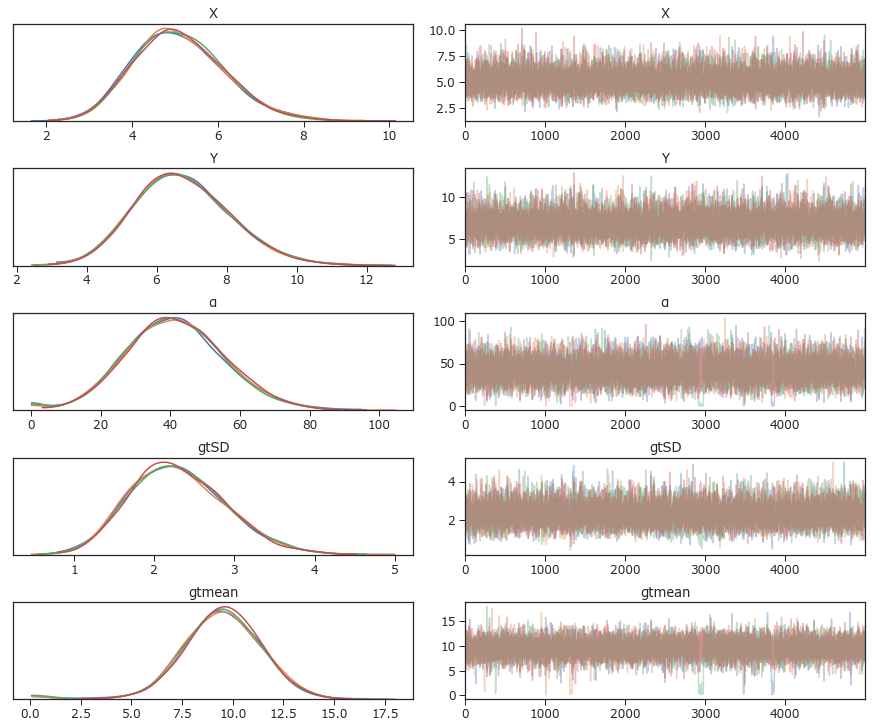

In [45]:
### Generation time distribution = Incubation time convoluted with infectiousness period
with pm.Model() as model:
    # incubation times
    incmean = tt.as_tensor_variable(np.float64(6.3))
    incSD = tt.as_tensor_variable(np.float64(1.3))
    X = pm.Gamma('X',mu=incmean,sd=incSD)
    # infectiousness period
    infmean = tt.as_tensor_variable(np.float64(9.15))
    infSD = tt.as_tensor_variable(np.float64(1.92))
    Y = pm.Gamma('Y',mu=infmean,sd=infSD)
    
    # generation time inference as convolution X*Y
    α = pm.HalfNormal('α',20)
    gtSD = pm.HalfNormal('gtSD')
    β = pm.math.sqrt(α/gtSD)
    Z = pm.Gamma('Z',α,β,observed=X+Y)
    pm.Deterministic('gtmean',α/β)
    
    trace = pm.sample(5000,tune=3000,init='advi')
    
az.plot_trace(trace)
pm.summary(trace,var_names=['gtmean','gtSD'])

In [52]:
resFit = pm.summary(trace,var_names=['gtmean','gtSD'])
genmean = resFit.loc['gtmean','mean']
gensd = resFit.loc['gtSD','mean']
(genmean,gensd)

(9.455843193165641, 2.304795326689438)

# Salje et al method

In [15]:
Distance = np.zeros([Df.shape[0]]*2)
for index_infector, index_infectee in itertools.product(np.arange(Df.shape[0]),np.arange(Df.shape[0])):
    coords_infectee = tuple((Df.loc[index_infectee,['Lat','Lon']]).values)
    coords_infector = tuple((Df.loc[index_infector,['Lat','Lon']]).values)
    Distance[index_infectee,index_infector] = geopy.distance.distance(coords_infectee, coords_infector).km

Distance = shared(Distance)
Distance.eval()

array([[  0.        , 307.71552104, 126.58317209, ..., 221.46522787,
        186.45524646, 187.08235969],
       [307.71552104,   0.        , 182.82805912, ..., 272.9746808 ,
        269.60444749, 250.74599031],
       [126.58317209, 182.82805912,   0.        , ..., 207.11454243,
        181.0554526 , 169.13442016],
       ...,
       [221.46522787, 272.9746808 , 207.11454243, ...,   0.        ,
         35.14542722,  38.62081526],
       [186.45524646, 269.60444749, 181.0554526 , ...,  35.14542722,
          0.        ,  18.98026048],
       [187.08235969, 250.74599031, 169.13442016, ...,  38.62081526,
         18.98026048,   0.        ]])

In [55]:
%%time
recalc = True

nsamples_ = 25
gammaF = lambda t,gtmean,gtSD: gammainc((gtmean/gtSD)**2, gtmean*t/(gtSD**2))
gammaProb = lambda day,gtmean,gtSD: gammaF(day,gtmean,gtSD) - gammaF(day-1,gtmean,gtSD) if day>0 else 0.0

if(recalc):
    print((genmean,gensd))
    genProb = lambda day: gammaProb(day,genmean,genSD)

    WallingaMatrix = np.zeros([Df.shape[0]]*2)
    for index_infector, index_infectee in itertools.product(np.arange(Df.shape[0]),np.arange(Df.shape[0])):
        time_infectee = Df.loc[index_infectee,'day']
        time_infector = Df.loc[index_infector,'day']
        WallingaMatrix[index_infectee,index_infector] = genProb(time_infectee-time_infector)
    WallingaMatrix = shared(WallingaMatrix)

    with pm.Model() as model:
        failed_to_connect = tt.switch(tt.gt(WallingaMatrix.max(axis=1),0),0,1)
        p = pm.Deterministic('p',tt.concatenate([WallingaMatrix,tt.shape_padright(failed_to_connect)],axis=1))
        connectivity_ = pm.Categorical('connectivity_',p=p,shape=Df.shape[0])
        connectivity = pm.Deterministic('connectivity',tt.switch(tt.lt(connectivity_,Df.shape[0]),
                                                                 connectivity_,
                                                                 -1))
        trace = pm.sample_prior_predictive(samples=nsamples_) 

    def calc(idx):
        res_ = trace['connectivity'][idx]
        connections = [(x,y) for x,y in enumerate(res_) if y>=0]
        G = nx.Graph()
        G.add_edges_from(connections)
        X = []
        for xx in range(Df.shape[0]):
            for yy in range(xx):
                try:
                    connections = list(nx.all_simple_paths(G, source=yy, target=xx))
                    if len(connections)>0:
                        X.append([yy, xx, len(connections[0])-1])
                except:
                    pass
        G.clear()
        return(X)

    X = Parallel(n_jobs=num_cores)(delayed(calc)(i) for i in range(nsamples_))
    df_connections =  pd.DataFrame(sum(X,[]),columns=['infector','infectee','θ'])
                
    res_ = []
    gdf = df_connections.groupby(['infector','infectee'])
    for k, gp in gdf:
        gpd = gp['θ'].value_counts()
        denominator_eq_8 = sum([np.sqrt(2*np.pi*idx)*gpd[idx]/len(gp) for idx in gpd.index])
        numerator_eq_8 = 2*Distance.eval()[k[0],k[1]]
        res_ = np.r_[res_,[numerator_eq_8/denominator_eq_8]]

    output = [genmean,gensd,np.mean(res_)]
    display(output)

(9.455843193165641, 2.304795326689438)


[9.455843193165641, 2.304795326689438, 57.65296272181223]

CPU times: user 2min 20s, sys: 2.85 s, total: 2min 23s
Wall time: 5min 59s


In [57]:
output0 = [0,output[-1]]
output0

[0, 57.65296272181223]

In [64]:
filename = "SaljeEstimation_ADSM.csv"
File = open(filename, 'w')
writer = csv.writer(File,lineterminator='\n')
writer.writerow(output0)
File.close()

In [59]:
Df0 = Df.copy()

In [65]:
%%time
recalc = True

step = 0.02
if(recalc):
    for fraction_to_be_removed in 1-np.arange(.06,1,step):
        print(fraction_to_be_removed)
        Df = Df0.iloc[rndm.sample(range(Df0.shape[0]),int(Df0.shape[0]*(1-fraction_to_be_removed)))].reset_index(drop=True).copy()

        WallingaMatrix = np.zeros([Df.shape[0]]*2)
        for index_infector, index_infectee in itertools.product(np.arange(Df.shape[0]),np.arange(Df.shape[0])):
            time_infectee = Df.loc[index_infectee,'day']
            time_infector = Df.loc[index_infector,'day']
            WallingaMatrix[index_infectee,index_infector] = genProb(time_infectee-time_infector)
        WallingaMatrix = shared(WallingaMatrix)

        with pm.Model() as model:
            failed_to_connect = tt.switch(tt.gt(WallingaMatrix.max(axis=1),0),0,1)
            p = pm.Deterministic('p',tt.concatenate([WallingaMatrix,tt.shape_padright(failed_to_connect)],axis=1))
            connectivity_ = pm.Categorical('connectivity_',p=p,shape=Df.shape[0])
            connectivity = pm.Deterministic('connectivity',tt.switch(tt.lt(connectivity_,Df.shape[0]),
                                                                     connectivity_,
                                                                     -1))
            trace = pm.sample_prior_predictive(samples=nsamples_) 

        def calc(idx):
            res_ = trace['connectivity'][idx]
            connections = [(x,y) for x,y in enumerate(res_) if y>=0]
            G = nx.Graph()
            G.add_edges_from(connections)
            X = []
            for xx in range(Df.shape[0]):
                for yy in range(xx):
                    try:
                        connections = list(nx.all_simple_paths(G, source=yy, target=xx))
                        if len(connections)>0:
                            X.append([yy, xx, len(connections[0])-1])
                    except:
                        pass
            G.clear()
            return(X)

        X = Parallel(n_jobs=num_cores)(delayed(calc)(i) for i in range(nsamples_))
        df_connections =  pd.DataFrame(sum(X,[]),columns=['infector','infectee','θ'])

        res_ = []
        gdf = df_connections.groupby(['infector','infectee'])
        for k, gp in gdf:
            gpd = gp['θ'].value_counts()
            denominator_eq_8 = sum([np.sqrt(2*np.pi*idx)*gpd[idx]/len(gp) for idx in gpd.index])
            numerator_eq_8 = 2*Distance.eval()[k[0],k[1]]
            res_ = np.r_[res_,[numerator_eq_8/denominator_eq_8]]

        File = open(filename, 'a')
        writer = csv.writer(File,lineterminator='\n')
        output = [fraction_to_be_removed,np.mean(res_)]
        writer.writerow(output)
        File.close()

        display(output)
        
print("Haha! Finished")

0.94


[0.94, 102.79013744489836]

0.92


[0.92, 101.50254281896734]

0.9


[0.9, 92.41473380000822]

0.88


[0.88, 94.6891637984791]

0.86


[0.86, 82.94184427899269]

0.84


[0.84, 82.94655338592497]

0.82


[0.82, 80.78171667094803]

0.8


[0.8, 81.94492590239008]

0.78


[0.78, 78.58534405582803]

0.76


[0.76, 72.19309973731131]

0.74


[0.74, 73.72795320714363]

0.72


[0.72, 71.93589610532753]

0.7


[0.7, 70.06745993840066]

0.6799999999999999


[0.6799999999999999, 71.88249527777157]

0.6599999999999999


[0.6599999999999999, 74.12938199698458]

0.6399999999999999


[0.6399999999999999, 70.93933346190303]

0.6199999999999999


[0.6199999999999999, 68.79275902853033]

0.5999999999999999


[0.5999999999999999, 66.89648913441415]

0.5799999999999998


[0.5799999999999998, 66.53528424758163]

0.5599999999999999


[0.5599999999999999, 63.18192570508502]

0.5399999999999999


[0.5399999999999999, 64.5039349244738]

0.5199999999999999


[0.5199999999999999, 66.85749784651497]

0.5


[0.5, 66.6507335349805]

0.48


[0.48, 67.05088084619797]

0.45999999999999996


[0.45999999999999996, 64.55717898834001]

0.43999999999999995


[0.43999999999999995, 63.159609074426236]

0.41999999999999993


[0.41999999999999993, 63.1216172944876]

0.3999999999999999


[0.3999999999999999, 62.52557957327932]

0.3799999999999999


[0.3799999999999999, 61.18480270705345]

0.3599999999999999


[0.3599999999999999, 60.73228348831462]

0.33999999999999986


[0.33999999999999986, 60.71347265580041]

0.31999999999999984


[0.31999999999999984, 59.678564914833984]

0.2999999999999998


[0.2999999999999998, 60.5985631397089]

0.2799999999999998


[0.2799999999999998, 60.26330404971994]

0.2599999999999998


[0.2599999999999998, 61.2996056145568]

0.23999999999999977


[0.23999999999999977, 60.22891556698308]

0.21999999999999975


[0.21999999999999975, 60.30134599937866]

0.19999999999999996


/home/aakhmetz/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[0.19999999999999996, 60.281056383201296]

0.17999999999999994


[0.17999999999999994, 60.72919063300967]

0.15999999999999992


[0.15999999999999992, 60.1251955369546]

0.1399999999999999


[0.1399999999999999, 59.58493372647406]

0.11999999999999988


[0.11999999999999988, 60.072101358364094]

0.09999999999999987


[0.09999999999999987, 59.441089683092486]

0.07999999999999985


[0.07999999999999985, 58.58546344724405]

0.05999999999999983


[0.05999999999999983, 58.72356304041814]

0.039999999999999813


[0.039999999999999813, 58.10545047472247]

0.019999999999999796


[0.019999999999999796, 58.45573090457968]

Haha! Finished
CPU times: user 37min 34s, sys: 17.5 s, total: 37min 51s
Wall time: 1h 20min 26s


## removing *ONLY GEOLOCATIONS* at random

In [71]:
filename = "SaljeEstimation_ADSM_only_geolocations.csv"
File = open(filename, 'w')
writer = csv.writer(File,lineterminator='\n')
writer.writerow(output0)
File.close()

In [72]:
%%time
recalc = True

step = 0.02
if(recalc):
    for fraction_to_be_removed in 1-np.arange(0.06,1,step):
        print(fraction_to_be_removed)
        nodes_to_keep = rndm.sample(range(Df.shape[0]),int(Df.shape[0]*(1-fraction_to_be_removed)))
        Df = Df0.reset_index(drop=True).copy()

        WallingaMatrix = np.zeros([Df.shape[0]]*2)
        for index_infector, index_infectee in itertools.product(np.arange(Df.shape[0]),np.arange(Df.shape[0])):
            time_infectee = Df.loc[index_infectee,'day']
            time_infector = Df.loc[index_infector,'day']
            WallingaMatrix[index_infectee,index_infector] = genProb(time_infectee-time_infector)
        WallingaMatrix = shared(WallingaMatrix)

        with pm.Model() as model:
            failed_to_connect = tt.switch(tt.gt(WallingaMatrix.max(axis=1),0),0,1)
            p = pm.Deterministic('p',tt.concatenate([WallingaMatrix,tt.shape_padright(failed_to_connect)],axis=1))
            connectivity_ = pm.Categorical('connectivity_',p=p,shape=Df.shape[0])
            connectivity = pm.Deterministic('connectivity',tt.switch(tt.lt(connectivity_,Df.shape[0]),
                                                                     connectivity_,
                                                                     -1))
            trace = pm.sample_prior_predictive(samples=nsamples_) 

        def calc(idx):
            res_ = trace['connectivity'][idx]
            connections = [(x,y) for x,y in enumerate(res_) if y>=0]
            G = nx.Graph()
            G.add_edges_from(connections)
            X = []
            for xx in range(len(nodes_to_keep)):
                for yy in range(xx):
                    try:
                        src_ = nodes_to_keep[yy]
                        trg_ = nodes_to_keep[xx]
                        connections = list(nx.all_simple_paths(G, source=src_, target=trg_))
                        if len(connections)>0:
                            X.append([src_, trg_, len(connections[0])-1])
                    except:
                        pass
            G.clear()
            return(X)

        X = Parallel(n_jobs=num_cores)(delayed(calc)(i) for i in range(nsamples_))
        df_connections =  pd.DataFrame(sum(X,[]),columns=['infector','infectee','θ'])

        res_ = []
        gdf = df_connections.groupby(['infector','infectee'])
        for k, gp in gdf:
            gpd = gp['θ'].value_counts()
            denominator_eq_8 = sum([np.sqrt(2*np.pi*idx)*gpd[idx]/len(gp) for idx in gpd.index])
            numerator_eq_8 = 2*Distance.eval()[k[0],k[1]]
            res_ = np.r_[res_,[numerator_eq_8/denominator_eq_8]]

        File = open(filename, 'a')
        writer = csv.writer(File,lineterminator='\n')
        output = [fraction_to_be_removed,np.mean(res_)]
        writer.writerow(output)
        File.close()

        display(output)
        
print("Haha! Finished")

0.94


[0.94, 54.43541541511973]

0.92


[0.92, 54.672275941662186]

0.9


[0.9, 61.105771167394394]

0.88


[0.88, 61.60842734681639]

0.86


[0.86, 60.06364894591414]

0.84


[0.84, 61.18953700682879]

0.82


[0.82, 57.52895084285842]

0.8


[0.8, 54.582324266909104]

0.78


[0.78, 58.496868723187774]

0.76


[0.76, 56.733114391597155]

0.74


[0.74, 56.800672879176055]

0.72


[0.72, 56.528168727382266]

0.7


[0.7, 56.830136458741144]

0.6799999999999999


[0.6799999999999999, 58.55868111900115]

0.6599999999999999


[0.6599999999999999, 55.89307750988009]

0.6399999999999999


[0.6399999999999999, 58.88609270130776]

0.6199999999999999


[0.6199999999999999, 55.15188803409552]

0.5999999999999999


[0.5999999999999999, 57.572984404295354]

0.5799999999999998


[0.5799999999999998, 58.198479556995096]

0.5599999999999999


[0.5599999999999999, 57.311367603822355]

0.5399999999999999


[0.5399999999999999, 57.41508270605598]

0.5199999999999999


[0.5199999999999999, 60.37606074504331]

0.5


[0.5, 57.827528657085224]

0.48


[0.48, 57.60244166438654]

0.45999999999999996


[0.45999999999999996, 58.03855413751023]

0.43999999999999995


[0.43999999999999995, 58.123644208631084]

0.41999999999999993


[0.41999999999999993, 59.42370177840809]

0.3999999999999999


[0.3999999999999999, 58.56182766796723]

0.3799999999999999


[0.3799999999999999, 58.7560902508324]

0.3599999999999999


[0.3599999999999999, 57.404634835403606]

0.33999999999999986


[0.33999999999999986, 58.84717460248958]

0.31999999999999984


[0.31999999999999984, 57.79899932597008]

0.2999999999999998


[0.2999999999999998, 58.21666004729835]

0.2799999999999998


[0.2799999999999998, 58.22775530469945]

0.2599999999999998


[0.2599999999999998, 58.55283346086718]

0.23999999999999977


[0.23999999999999977, 59.067329086797926]

0.21999999999999975


[0.21999999999999975, 57.76320563145337]

0.19999999999999996


[0.19999999999999996, 57.89040072911433]

0.17999999999999994


[0.17999999999999994, 58.305948462555364]

0.15999999999999992


[0.15999999999999992, 57.826594227540134]

0.1399999999999999


[0.1399999999999999, 58.71901936617389]

0.11999999999999988


[0.11999999999999988, 58.29961465627597]

0.09999999999999987


[0.09999999999999987, 59.17715522996332]

0.07999999999999985


[0.07999999999999985, 58.345665426719684]

0.05999999999999983


[0.05999999999999983, 58.26186185950772]

0.039999999999999813


[0.039999999999999813, 58.49744580400566]

0.019999999999999796


[0.019999999999999796, 58.57679188913191]

Haha! Finished
CPU times: user 40min 4s, sys: 30.5 s, total: 40min 35s
Wall time: 1h 37min 19s


In [75]:
res = pd.read_csv("SaljeEstimation_ADSM-final.csv",sep=",",names=['type','fraction_removed','mu'],skiprows=1)
res[:5]

,type,fraction_removed,mu
0,both,0.00,57.652963
1,both,0.94,102.790137
2,both,0.92,101.502543
3,both,0.90,92.414734
4,both,0.88,94.689164


In [95]:
mean_distance_all_data = res.loc[lambda d: d.fraction_removed==0].mu.mean()
mean_distance_all_data

57.65296272

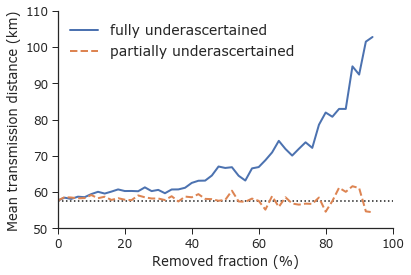

In [225]:
fig, ax = plt.subplots(1)
fig.set_size_inches(6,4);

res = res.sort_values('fraction_removed')

lbs = ['fully underascertained',
       'partially underascertained']
lss = sum([['solid'],['dashed']],[])
for idx,tp in enumerate(['both','only_geolocations']):
    res_ = res.loc[lambda d: d['type']==tp]
    ax.plot(res_.fraction_removed,res_.mu,label=lbs[idx],lw=2,ls=lss[idx],color='C'+str(idx))

ax.set_xlim(0,1)
step = .2
xtks = np.arange(0,1+step,step)
ax.set_xticks(xtks)
ax.set_xticklabels([int(100*x) for x in xtks])
ax.set_xlabel('Removed fraction (%)')
ax.set_ylabel('Mean transmission distance (km)')
ax.axhline(mean_distance_all_data,c='k',ls='dotted',zorder=-5)
ax.set_ylim(50,110)

ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
ax.legend(frameon=False,title_fontsize=12)
plt.savefig("../../figures/draft/AppendixFig-ADSM-Salje.pdf",format='pdf',bbox_inches='tight')

In [164]:
from bs4 import BeautifulSoup
flnm = 'ADSM-Sample_population.xml'
with open(flnm,'rb') as fd:
    soup = BeautifulSoup(fd,'xml')
cells = soup.find_all()
cells = [cell.get_text() for cell in cells]

zz = [i for i,cell in enumerate(cells) if (cell=='Swine')]
output = None
for idx,z in enumerate(zz):
    res_ = [float(cells[z+3]),float(cells[z+4])]
    output = np.r_[output,[res_]] if idx else [res_]
df_smpl = pd.DataFrame(output,columns=['lat','long'])
df_smpl

,lat,long
0,35.74069,-33.94548
1,33.41808,-35.25260
2,36.08720,-34.33728
3,34.54750,-35.05291
4,33.51475,-37.56755
...,...,...
456,34.09074,-33.10716
457,33.90047,-33.31553
458,33.91208,-32.93893
459,33.81213,-33.29934


In [165]:
df_smpl.to_csv('ADSM-Sample_population.csv')

In [174]:
df_smpl_min = df_smpl.min()
df_smpl_min

lat     32.30871
long   -38.24372
dtype: float64

In [172]:
df_smpl_max = df_smpl.max()
df_smpl_max

lat     37.60544
long   -31.78643
dtype: float64

In [175]:
df_smpl_max.lat-df_smpl_min.lat

5.296730000000004

In [176]:
df_smpl_max.long-df_smpl_min.long

6.457290000000004

In [184]:
radius = geopy.distance.distance((df_smpl_min.lat,df_smpl_min.long), (df_smpl_max.lat,df_smpl_max.long)).km/np.sqrt(2)
radius

588.390447234561

In [201]:
len(df_smpl)

461